In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, TimeDistributed, Reshape, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Chemin vers les dossiers de données
base_dir = r'C:\Users\nabil\Desktop\YNOV M2\Deep learning\Projet\Data\chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Générateurs de données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=1, class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


c:\Users\nabil\anaconda3\envs\TP_ML2\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 739ms/step - accuracy: 0.7654 - loss: 0.5914 - val_accuracy: 0.5000 - val_loss: 0.7501
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 764ms/step - accuracy: 0.7332 - loss: 0.4787 - val_accuracy: 0.5000 - val_loss: 0.8936
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - accuracy: 0.7238 - loss: 0.4726 - val_accuracy: 0.5625 - val_loss: 0.6856
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 521ms/step - accuracy: 0.7557 - loss: 0.4247 - val_accuracy: 0.5625 - val_loss: 0.7671
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 509ms/step - accuracy: 0.7891 - loss: 0.3894 - val_accuracy: 0.7500 - val_loss: 0.6148
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 481ms/step - accuracy: 0.8242 - loss: 0.3595 - val_accuracy: 0.7500 - val_loss: 0.6664
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 483ms/step - accuracy: 0.8268 - loss: 0.3568 - val_accuracy: 0.8750 - val_loss: 0.4877
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 488ms/step - accuracy: 0.8405 - loss: 0

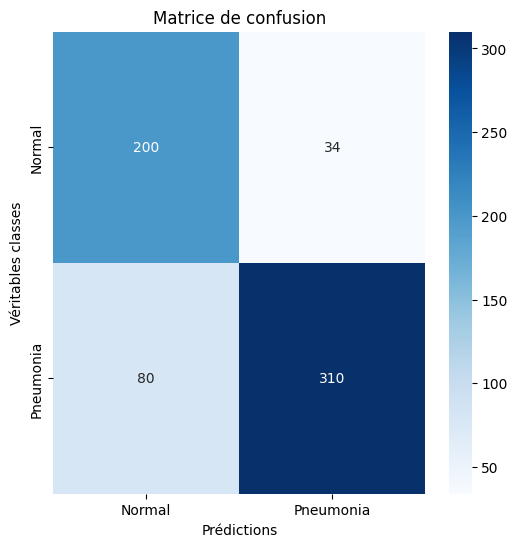

              precision    recall  f1-score   support

      Normal       0.71      0.85      0.78       234
   Pneumonia       0.90      0.79      0.84       390

    accuracy                           0.82       624
   macro avg       0.81      0.82      0.81       624
weighted avg       0.83      0.82      0.82       624



In [4]:
# Modèle
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(1, 150, 150, 3)),

    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),

    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Conv2D(128, (3, 3), activation='relu')),

    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Flatten()),
        
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

# Adapter les données d'entrée pour ajouter une dimension temporelle
def add_time_dimension(generator):
    for batch_x, batch_y in generator:
        batch_x_with_time = np.expand_dims(batch_x, 1)  # Ajoute une dimension temporelle
        yield batch_x_with_time, batch_y

# Entraînement du modèle
history = model.fit(
    add_time_dimension(train_generator),
    steps_per_epoch=100,  # Ajustez selon la taille de votre ensemble
    epochs=10,
    validation_data=add_time_dimension(validation_generator),
    validation_steps=50,  # Ajustez selon la taille de votre ensemble

)

# Prédiction sur l'ensemble de test
test_generator.reset()
predictions = model.predict(add_time_dimension(test_generator), steps=len(test_generator))

# Classifier les prédictions
predicted_classes = (predictions > 0.66374086).astype(int)

# Matrice de confusion et statistiques
true_classes = test_generator.classes
cm = confusion_matrix(true_classes, predicted_classes)
report = classification_report(true_classes, predicted_classes, target_names=['Normal', 'Pneumonia'])

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables classes')
plt.show()

# Affichage des statistiques
print(report)

In [8]:
epochs = range(1, len(history.history['accuracy']) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

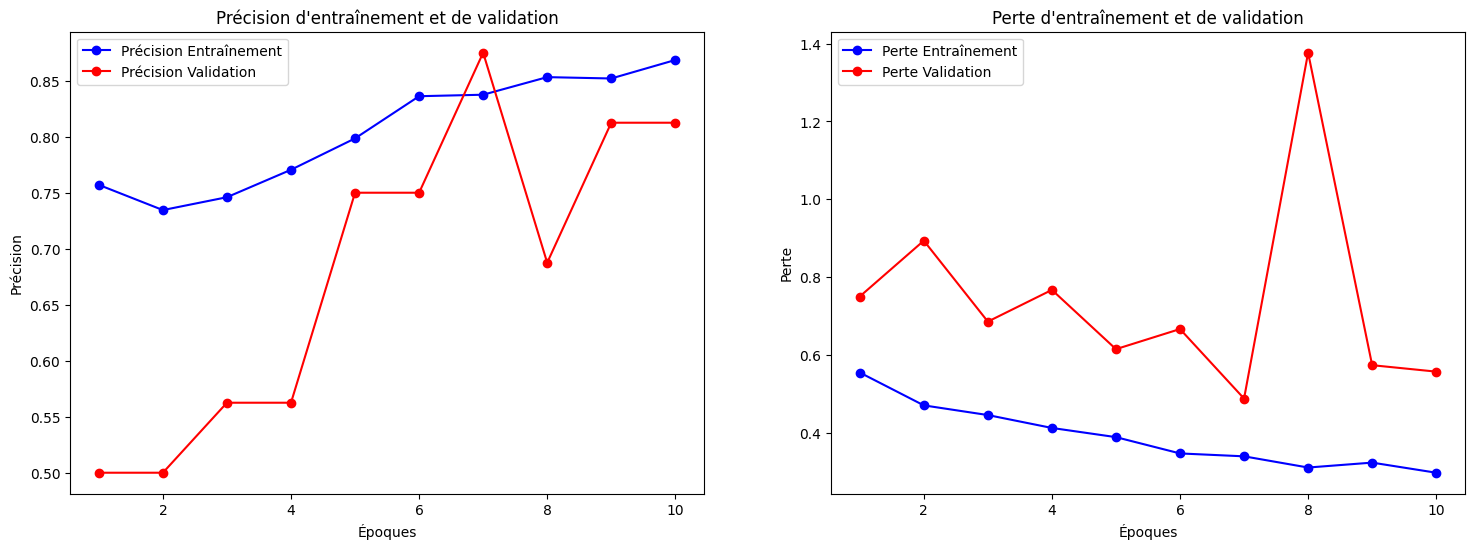

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Précision
ax1.plot(epochs, acc, 'bo-', label='Précision Entraînement')
ax1.plot(epochs, val_acc, 'ro-', label='Précision Validation')
ax1.set_title('Précision d\'entraînement et de validation')
ax1.set_xlabel('Époques')
ax1.set_ylabel('Précision')
ax1.legend()

# Perte
ax2.plot(epochs, loss, 'bo-', label='Perte Entraînement')
ax2.plot(epochs, val_loss, 'ro-', label='Perte Validation')
ax2.set_title('Perte d\'entraînement et de validation')
ax2.set_xlabel('Époques')
ax2.set_ylabel('Perte')
ax2.legend()

plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step


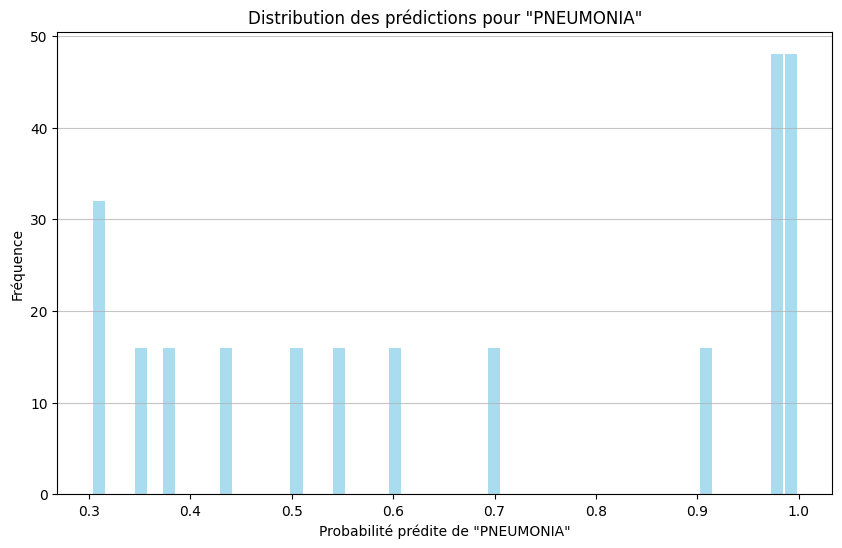

In [10]:
def add_time_dimension_to_generator(generator):
    for batch_x, batch_y in generator:
        # Ajoute une dimension temporelle de taille 1
        batch_x_with_time = np.expand_dims(batch_x, axis=1)
        yield batch_x_with_time, batch_y

# Créez un nouveau générateur avec la dimension temporelle ajoutée
validation_generator_with_time = add_time_dimension_to_generator(validation_generator)

# Calculez le nombre de pas (nombre total d'images dans le générateur)
steps = len(validation_generator.filenames)

# Faites la prédiction avec le nouveau générateur
predictions = model.predict(validation_generator_with_time, steps=steps)

# Affichez la distribution des prédictions
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=50, color='skyblue', alpha=0.7, rwidth=0.85)
plt.title('Distribution des prédictions pour "PNEUMONIA"')
plt.xlabel('Probabilité prédite de "PNEUMONIA"')
plt.ylabel('Fréquence')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [11]:
# Calculer le nombre de prédictions pour chaque classe
num_pneumonia = np.sum(predicted_classes)
num_normal = len(predicted_classes) - num_pneumonia

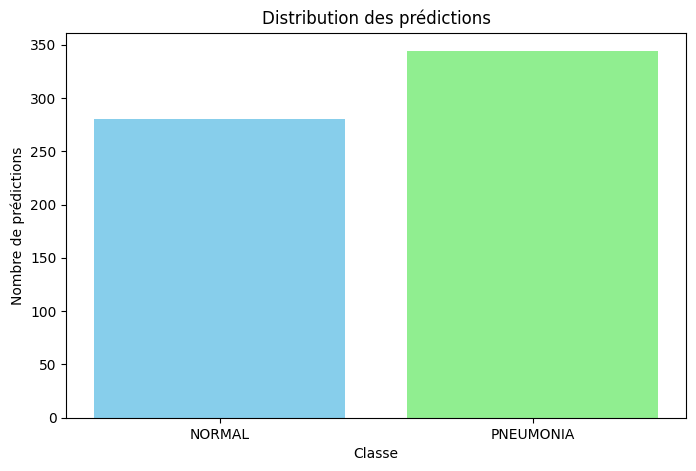

In [12]:
classes = ['NORMAL', 'PNEUMONIA']
counts = [num_normal, num_pneumonia]

plt.figure(figsize=(8, 5))
plt.bar(classes, counts, color=['skyblue', 'lightgreen'])
plt.title('Distribution des prédictions')
plt.xlabel('Classe')
plt.ylabel('Nombre de prédictions')
plt.show()

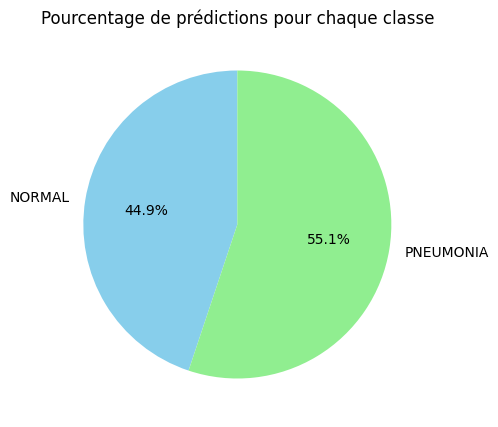

In [13]:
plt.figure(figsize=(8, 5))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Pourcentage de prédictions pour chaque classe')
plt.show()

In [14]:
np.save('confusion_matrix.npy', cm)
np.save('report.npy', report)

In [17]:
model.save("C:\\Users\\nabil\\Desktop\\YNOV M2\\Deep learning\\Projet\\projet_partie1_DL_ynov.keras")

In [18]:
from sklearn.metrics import classification_report
import json

report = classification_report(true_classes, predicted_classes, target_names=['Normal', 'Pneumonia'], output_dict=True)

# Sauvegarder le rapport de classification dans un fichier JSON
with open('classification_report.json', 'w') as f:
    json.dump(report, f)

In [19]:
history_dict = history.history

# Sauvegarde des données dans un fichier CSV
import pandas as pd

# Crée un DataFrame avec les données history
history_df = pd.DataFrame(history_dict)
history_df['epoch'] = history.epoch

history_df.to_csv('training_history.csv', index=False)

In [20]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 148, 148,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 74, 74, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 72, 72, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 1, 36, 36, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1, 34, 34, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 1, 17, 17, 128) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 1, 36992)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     9,486,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,739,717 (109.63 MB)

 Trainable params: 9,579,905 (36.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,159,812 (73.09 MB)

None
